As a part of the final IBM Capstone Project, we work on the real dataset to get an exprencies of what a data scientists go through in real life. Objectives of the final assignments were to define a business problem, look for data in the web and, use Foursquare location data to compare different neighborhoods of Toronto to figure out which neighborhood is suitable for starting a new restaurant business. In this project, I go through all the process in a step by step manner from problem designing, data preparation to final analysis and finally will provide a conclusion that can be leveraged by the business stakeholders to make their decisions.

# Introduction/Business Problem Discussion
##### Prospects of a opening a Chinese Restaurant in Toronto, Canada.
Toronto, the capital of the province of Ontario, is the most populous Canadian city. Its heavy diversity is reflected in Toronto’s ethnic neighborhoods such as Chinatown, Corso Italia, Greektown, Kensington Market, Koreatown, Little India, Little Italy, Little Jamaica, Little Portugal & Roncesvalles. One of the most immigrant-friendly cities in North America with a large portion if its Chinese population residing in Toronto, it hashigh potential to be a great place to start an Chinese restaurant.
##### Business Problem
In this project we will go through step by step process to make a decision whether it is a good idea to open a Chinese restaurant and in which neighborhood to do so in. We analyze the neighborhoods in Toronto to identify the most profitable area since the success of the restaurant depends on the people and ambience. While Chinatown might seem like an obvious choice, we wean to explore potential areas with high Chinese populations that do not have a chinese restaurants to capture strong marketshare.
##### Target Audience
This is a common problem for many restuarant investors and entreperneurs. This analysis will be a comprehensive guide to start or expand restaurants targeting the Chinese population. This may also help
Freelancers whom love to have their own restaurant as a side business. This analysis will give an idea, how beneficial it is to open a restaurant and what are the pros and cons of this business.
Chinese people who are newly minted Toronto residents may also find this helpful to find new restaurants near them in their neighborhood. Lastly, Business Analysts or Data Scientists, who wish to analyze the neighborhoods of Toronto using Exploratory Data Analysis and other statistical & machine learning techniques to obtain all the necessary data, perform some operations on it and, finally be able to tell a story out of it may find this useful. Lastly, people who live in the toronto area that are looking for new chinese restaurants to try may also benefit from the result of this project.

# Data Discussion

##### Data Sources
For this project, I will be leveraging a number of data sources, some from previous labs in this course and some new data sources. The complete list is as follows:
1. List of Tornoto Neighborhoods and thweir postal codes. “List of Postal code of Canada: M” (https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M) wiki page to get all the information about the neighborhoods present in Toronto. This page has the postal code, borough & the name of all the neighborhoods present in Toronto.

2. Latitude and Longitude data. Also from previus labs: “https://cocl.us/Geospatial_data” csv file to get all the geographical coordinates of the neighborhoods in Toronto.

3. Ethinicity population distribution of Toronto. To get information about the distribution of population by their ethnicity, we'll leverage “Demographics of Toronto” (https://en.m.wikipedia.org/wiki/Demographics_of_Toronto#Ethnic_diversity) wiki page. Using this page I’m going to identify the neighborhoods which are densely populated with Chinese people as it might be helpful in identifying the suitable neighborhood to open a new chinese restaurant.

4. Venue and location data. Also from previous labs and as a requirement for this project, to get location and other information about various venues in Toronto, I’m using Foursquare’s explore API. Using the Foursquare’s explore API (which gives venues recommendations), I’m fetching details about the venues up present in Toronto and collected their names, categories and locations (latitude and longitude). From Foursquare API (https://developer.foursquare.com/docs), I retrieved the following for each venue:

    - Name: The name of the venue.
    - Category: The category type as defined by the API.
    - Latitude: The latitude value of the venue.
    - Longitude: The longitude value of the venue.

# Methodology

### Data Cleaning
The first part of our methodolgy is to prep and clean the data for use. We'll start by scraping the Toronto Neighborhoods Table from Wikipedia. The dataframe will consist of three columns: PostalCode, Borough, and Neighborhood
Only the cells that have an assigned borough will be processed. Borough that is not assigned are ignoredand if a cell has a borough but a Not assigned neighborhood, then the neighborhood will be the same as the borough.

First, we will import all of the relevant libraries for this analysis.

In [63]:
#Importand install all relevant libraries 
! pip install folium==0.5.0
! pip install wikipedia
! pip install yellowbrick

import pandas as pd
import numpy as np
import requests
import os
import folium 
import matplotlib.cm as cm
import matplotlib.colors as colors
import wikipedia as wp
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from bs4 import BeautifulSoup
from sklearn.cluster import KMeans
from geopy.geocoders import Nominatim 

%matplotlib inline

print('Libraries imported.')

Libraries imported.


##### Bringing in the Wikipedia table into a pandas Data Frame
Next, we'll bring in the neighborhoods with postal codes into a pandas dataframe from scraping a wikipedia page.

In [64]:
#Read html
source = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text
soup=BeautifulSoup(source,'lxml')
print(soup.title)
tab = str(soup.table)

# Read in html to pandas DF
dfs = pd.read_html(tab)
df=dfs[0]
df.head()


<title>List of postal codes of Canada: M - Wikipedia</title>


,Postal Code,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


In [65]:
# Dropping the rows where Borough is 'Not assigned'
df1 = df[df.Borough != 'Not assigned']

# Combining the neighbourhoods with same Postalcode
df2 = df1.groupby(['Postal Code','Borough'], sort=False).agg(', '.join)
df2.reset_index(inplace=True)

# Replacing the name of the neighbourhoods which are 'Not assigned' with names of Borough
df2['Neighbourhood'] = np.where(df2['Neighbourhood'] == 'Not assigned',df2['Borough'], df2['Neighbourhood'])

# Bringing in Latitude and Longitude Data
geo = pd.read_csv('https://cocl.us/Geospatial_data')

#Merge Data Sets
df3 = pd.merge(df2,geo,on='Postal Code')
df3.head()

df4 = df3[df3['Borough'].str.contains('Toronto',regex=False)]

df4 = df4.rename(columns={'Neighbourhood':'Neighborhood'})
df4.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
15,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
19,M4E,East Toronto,The Beaches,43.676357,-79.293031



### Scraping the population distribution (demographics) data from Wikipedia
An important factor that will help determin where an opitmal chinese restaurant would be is to detrmine which neighborhood has the highest chinese demographic. Here, we'll scrape wikipedia for the demographics of Toronto and pull out the neighborhoods that have a high chinese population. We also look at population density among the nighbor hoods in Toronto.

In [66]:
#overall population distribution 
html = wp.page("Demographics of Toronto").html().encode("UTF-8")


#TORONTO & EAST YORK population distribution by ethnicity 
TEY_population_df = pd.read_html(html, header = 0)[13]
TEY_population_df = TEY_population_df.rename(columns={'%':'Ethnic Origin 1 in %', 
                                                      '%.1':'Ethnic Origin 2 in %',
                                                     '%.2':'Ethnic Origin 3 in %',
                                                     '%.3':'Ethnic Origin 4 in %',
                                                     '%.4':'Ethnic Origin 5 in %',
                                                     '%.5':'Ethnic Origin 6 in %',
                                                     '%.6':'Ethnic Origin 7 in %',
                                                     '%.7':'Ethnic Origin 8 in %',
                                                     '%.8':'Ethnic Origin 9 in %'})
TEY_population_df.head()

,Riding,Population,Ethnic Origin #1,Ethnic Origin 1 in %,Ethnic Origin #2,Ethnic Origin 2 in %,Ethnic Origin #3,Ethnic Origin 3 in %,Ethnic Origin #4,Ethnic Origin 4 in %,Ethnic Origin #5,Ethnic Origin 5 in %,Ethnic Origin #6,Ethnic Origin 6 in %,Ethnic Origin #7,Ethnic Origin 7 in %,Ethnic Origin #8,Ethnic Origin 8 in %
0,Willowdale,117405,Chinese,25.9,Iranian,12.1,Korean,10.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Eglinton-Lawrence,112925,Canadian,14.7,English,12.6,Polish,12.0,Filipino,11.0,Scottish,9.7,Italian,9.5,Irish,9.2,Russian,8.4
2,Don Valley North,109060,Chinese,32.4,East Indian,7.3,Iranian,7.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Humber River-Black Creek,107725,Italian,12.8,East Indian,9.2,Jamaican,8.5,Vietnamese,8.0,Canadian,7.4,NaN,NaN,NaN,NaN,NaN,NaN
4,York Centre,103760,Filipino,17.0,Italian,13.4,Russian,9.5,Canadian,8.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [67]:
#NORTH YORK population distribution by ethnicity 
North_population_df = pd.read_html(html, header = 0)[14]
North_population_df = North_population_df.rename(columns={'%':'Ethnic Origin 1 in %', 
                                                      '%.1':'Ethnic Origin 2 in %',
                                                     '%.2':'Ethnic Origin 3 in %',
                                                     '%.3':'Ethnic Origin 4 in %',
                                                     '%.4':'Ethnic Origin 5 in %',
                                                     '%.5':'Ethnic Origin 6 in %',
                                                     '%.6':'Ethnic Origin 7 in %',
                                                     '%.7':'Ethnic Origin 8 in %'})
North_population_df.head()

,Riding,Population,Ethnic Origin #1,Ethnic Origin 1 in %,Ethnic Origin #2,Ethnic Origin 2 in %,Ethnic Origin #3,Ethnic Origin 3 in %,Ethnic Origin #4,Ethnic Origin 4 in %,Ethnic Origin #5,Ethnic Origin 5 in %,Ethnic Origin #6,Ethnic Origin 6 in %,Ethnic Origin #7,Ethnic Origin 7 in %,Ethnic Origin #8,Ethnic Origin 8 in %
0,Scarborough Centre,110450,Filipino,13.1,East Indian,12.2,Canadian,11.2,Chinese,10.7,English,7.8,Sri Lankan,7.0,NaN,NaN,NaN,NaN
1,Scarborough Southwest,108295,Canadian,16.2,English,14.3,Irish,11.5,Scottish,10.9,Filipino,9.5,East Indian,8.2,Chinese,7.2,NaN,NaN
2,Scarborough-Agincourt,104225,Chinese,47.0,East Indian,7.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Scarborough-Rouge Park,101445,East Indian,16.7,Canadian,11.8,Sri Lankan,11.1,English,9.8,Filipino,9.3,Jamaican,8.4,Scottish,7.2,Irish,7.0
4,Scarborough-Guildwood,101115,East Indian,18.0,Canadian,11.6,English,9.7,Filipino,8.5,Sri Lankan,7.8,Chinese,7.1,Scottish,7.0,NaN,NaN


In [68]:
#SCARBOROUGH population distribution by ethnicity 
Scar_population_df = pd.read_html(html, header = 0)[15]
Scar_population_df = Scar_population_df.rename(columns={'%':'Ethnic Origin 1 in %', 
                                                      '%.1':'Ethnic Origin 2 in %',
                                                     '%.2':'Ethnic Origin 3 in %',
                                                     '%.3':'Ethnic Origin 4 in %',
                                                     '%.4':'Ethnic Origin 5 in %',
                                                     '%.5':'Ethnic Origin 6 in %',
                                                     '%.6':'Ethnic Origin 7 in %',
                                                     '%.7':'Ethnic Origin 8 in %'})
Scar_population_df.head()

,Riding,Population,Ethnic Origin #1,Ethnic Origin 1 in %,Ethnic Origin #2,Ethnic Origin 2 in %,Ethnic Origin #3,Ethnic Origin 3 in %,Ethnic Origin #4,Ethnic Origin 4 in %,Ethnic Origin #5,Ethnic Origin 5 in %,Ethnic Origin #6,Ethnic Origin 6 in %,Ethnic Origin #7,Ethnic Origin 7 in %,Ethnic Origin #8,Ethnic Origin 8 in %
0,Etobicoke-Lakeshore,127520,English,17.1,Canadian,15.9,Irish,14.4,Scottish,13.5,Polish,9.2,Italian,9.1,Ukrainian,7.6,German,7.1
1,Etobicoke North,116960,East Indian,22.2,Canadian,7.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Etobicoke Centre,116055,Italian,15.1,English,14.3,Canadian,12.1,Irish,10.8,Scottish,10.4,Ukrainian,8.1,Polish,7.4,NaN,NaN
3,York South-Weston,115130,Portuguese,14.5,Italian,12.8,Canadian,8.7,Jamaican,8.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Toronto Visualization
Let's use Folium to visualize where our neighborhoods are in Torotno that we're considering opeingin up a chinese restaurant.

In [72]:
#Use geopy library to get the latitude and longitude values of New York City.

address = 'Toronto'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


In [73]:
map_toronto = folium.Map(location=[43.651070,-79.347015],zoom_start=12)

for lat,lng,borough,neighbourhood in zip(df4['Latitude'],df4['Longitude'],df4['Borough'],df4['Neighborhood']):
    label = '{}, {}'.format(neighbourhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
    [lat,lng],
    radius=7,
    popup=label,
    color='blue',
    fill=True,
    fill_opacity=0.7,
    parse_html=False).add_to(map_toronto)
map_toronto

In [ ]:
CLIENT_ID = 'YJLI4MNYVY31BA2SOYVE2U5X3BCU0EXC3YMUAKZVDLQYL0C4' # your Foursquare ID
CLIENT_SECRET = 'PLNOVZJWMLOXX34CO0SU3JFPYTJZZB40LMPUOOV1M0JNDFTB' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

### Get location data using Foursquare
Let's use the FourSquare API to bring in some poular venues near the Toronto area. The API returns a JSON file and we need to turn that into a data-frame. Here I’ve chosen 100 popular spots for each neighborhood within a radius of 1km.

In [74]:
radius=1000
url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, radius)
results = requests.get(url).json()

In [75]:
#Function to get the category

def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']

    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [76]:
import json
from pandas.io.json import json_normalize

venues = results['response']['groups'][0]['items']

nearby_venues = json_normalize(venues) # flatten JSON

filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:6: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead


,name,categories,lat,lng
0,Downtown Toronto,Neighborhood,43.653232,-79.385296
1,Nathan Phillips Square,Plaza,43.652270,-79.383516
2,Indigo,Bookstore,43.653515,-79.380696
3,UNIQLO ユニクロ,Clothing Store,43.655910,-79.380641
4,Chatime 日出茶太,Bubble Tea Shop,43.655542,-79.384684


In [77]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [78]:
LIMIT = 100
toronto_venues = getNearbyVenues(names=df4['Neighborhood'],
                                   latitudes=df4['Latitude'],
                                   longitudes=df4['Longitude']
                                  )
toronto_venues.head()

Regent Park, Harbourfront
Queen's Park, Ontario Provincial Government
Garden District, Ryerson
St. James Town
The Beaches
Berczy Park
Central Bay Street
Christie
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
The Danforth West, Riverdale
Toronto Dominion Centre, Design Exchange
Brockton, Parkdale Village, Exhibition Place
India Bazaar, The Beaches West
Commerce Court, Victoria Hotel
Studio District
Lawrence Park
Roselawn
Davisville North
Forest Hill North & West, Forest Hill Road Park
High Park, The Junction South
North Toronto West, Lawrence Park
The Annex, North Midtown, Yorkville
Parkdale, Roncesvalles
Davisville
University of Toronto, Harbord
Runnymede, Swansea
Moore Park, Summerhill East
Kensington Market, Chinatown, Grange Park
Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport
R

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Regent Park, Harbourfront",43.65426,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
1,"Regent Park, Harbourfront",43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
2,"Regent Park, Harbourfront",43.65426,-79.360636,Cooper Koo Family YMCA,43.653249,-79.358008,Distribution Center
3,"Regent Park, Harbourfront",43.65426,-79.360636,Body Blitz Spa East,43.654735,-79.359874,Spa
4,"Regent Park, Harbourfront",43.65426,-79.360636,Impact Kitchen,43.656369,-79.356980,Restaurant


In [79]:
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood']

fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped.head()

,Neighborhood,Yoga Studio,Adult Boutique,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Theater,Theme Restaurant,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar
0,Berczy Park,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.018182,0.0,0.0,0.000000
1,"Brockton, Parkdale Village, Exhibition Place",0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
2,"Business reply mail Processing Centre, South C...",0.062500,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
3,"CN Tower, King and Spadina, Railway Lands, Har...",0.000000,0.0,0.071429,0.071429,0.071429,0.071429,0.142857,0.071429,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
4,Central Bay Street,0.016129,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.016129,0.0,0.0,0.016129


In [80]:
toronto_part = toronto_grouped[['Neighborhood', 'Chinese Restaurant']]
toronto_part.head()

,Neighborhood,Chinese Restaurant
0,Berczy Park,0.000000
1,"Brockton, Parkdale Village, Exhibition Place",0.000000
2,"Business reply mail Processing Centre, South C...",0.000000
3,"CN Tower, King and Spadina, Railway Lands, Har...",0.000000
4,Central Bay Street,0.016129


In [81]:
toronto_merged = pd.merge(df4, toronto_part, on='Neighborhood')
toronto_merged.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Chinese Restaurant
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,0.00
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,0.00
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,0.01
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,0.00
4,M4E,East Toronto,The Beaches,43.676357,-79.293031,0.00


### Visualize where the Chinese restaurants are
Now that we have a dataframe whe relevant chinese restaurant by neighborhood data, let's take a look where their are have denaities of chinese restaurants in the Toronto area. We may want to avoid these areas as the restaurants there already have a large market share with heavy competition.

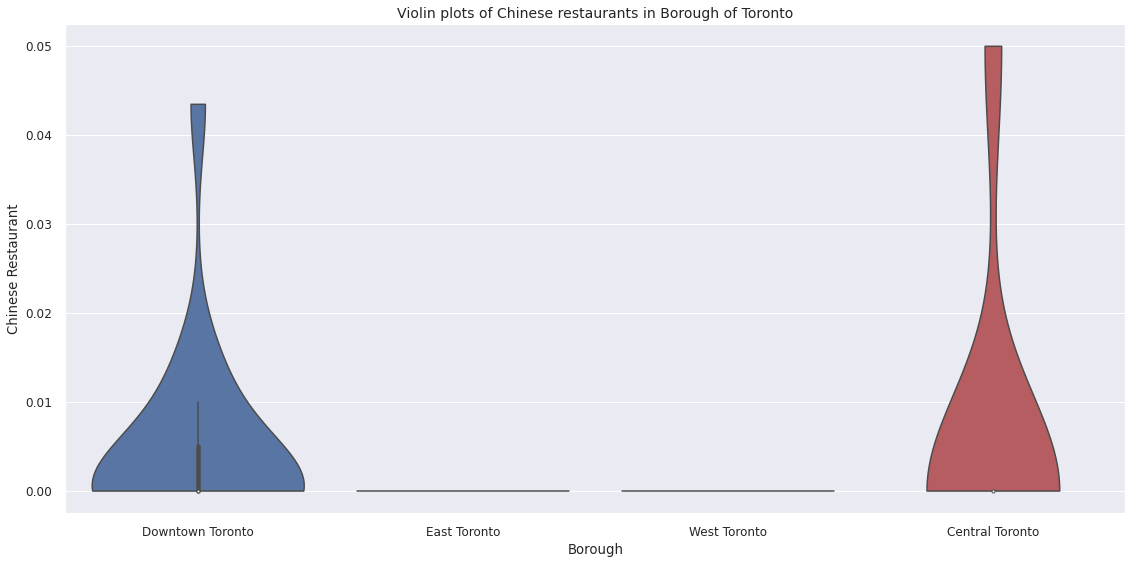

In [82]:
# Let's try Categorical plot 
fig = plt.figure(figsize=(19,9))

sns.set(font_scale=1.1)
sns.violinplot(y="Chinese Restaurant", x="Borough", data=toronto_merged, cut=0);

plt.title('Violin plots of Chinese restaurants in Borough of Toronto', fontsize=14)
plt.show()

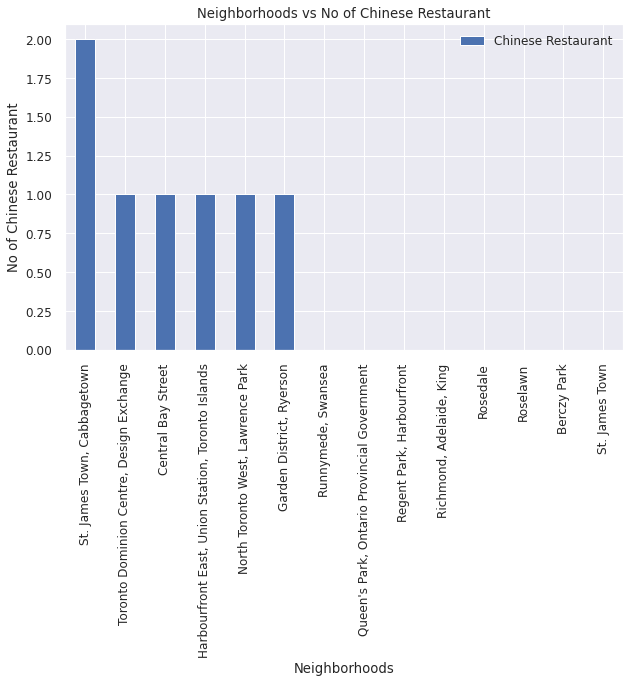

In [83]:
graph = pd.DataFrame(toronto_onehot.groupby('Neighborhood')['Chinese Restaurant'].sum())
graph = graph.sort_values(by ='Chinese Restaurant', ascending=False)
graph.iloc[:14].plot(kind='bar', figsize=(10,6))
plt.xlabel("Neighborhoods")
plt.ylabel("No of Chinese Restaurant")
plt.title("Neighborhoods vs No of Chinese Restaurant")
plt.show()

In [84]:
#Merge all the population table with the ethnic percentage by neighborhood
ET = TEY_population_df.reset_index()
ET.drop('index',axis=1,inplace=True)
SN = North_population_df.append(Scar_population_df,sort=True).reset_index()
SN.drop('index',axis=1,inplace=True)
pop_ethnic_df = SN.append(ET,sort=True).reset_index()
pop_ethnic_df.drop('index',axis=1,inplace=True)
pop_ethnic_df = pop_ethnic_df[['Riding', 'Population','Ethnic Origin #1', 'Ethnic Origin 1 in %','Ethnic Origin #2', 'Ethnic Origin 2 in %',
                               'Ethnic Origin #3','Ethnic Origin 3 in %','Ethnic Origin #4', 'Ethnic Origin 4 in %','Ethnic Origin #5','Ethnic Origin 5 in %', 
                               'Ethnic Origin #6','Ethnic Origin 6 in %','Ethnic Origin #7', 'Ethnic Origin 7 in %','Ethnic Origin #8', 'Ethnic Origin 8 in %',
                              ]]
pop_ethnic_df.head()

,Riding,Population,Ethnic Origin #1,Ethnic Origin 1 in %,Ethnic Origin #2,Ethnic Origin 2 in %,Ethnic Origin #3,Ethnic Origin 3 in %,Ethnic Origin #4,Ethnic Origin 4 in %,Ethnic Origin #5,Ethnic Origin 5 in %,Ethnic Origin #6,Ethnic Origin 6 in %,Ethnic Origin #7,Ethnic Origin 7 in %,Ethnic Origin #8,Ethnic Origin 8 in %
0,Scarborough Centre,110450,Filipino,13.1,East Indian,12.2,Canadian,11.2,Chinese,10.7,English,7.8,Sri Lankan,7.0,NaN,NaN,NaN,NaN
1,Scarborough Southwest,108295,Canadian,16.2,English,14.3,Irish,11.5,Scottish,10.9,Filipino,9.5,East Indian,8.2,Chinese,7.2,NaN,NaN
2,Scarborough-Agincourt,104225,Chinese,47.0,East Indian,7.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Scarborough-Rouge Park,101445,East Indian,16.7,Canadian,11.8,Sri Lankan,11.1,English,9.8,Filipino,9.3,Jamaican,8.4,Scottish,7.2,Irish,7.0
4,Scarborough-Guildwood,101115,East Indian,18.0,Canadian,11.6,English,9.7,Filipino,8.5,Sri Lankan,7.8,Chinese,7.1,Scottish,7.0,NaN,NaN


In [85]:
#Filtering the riding with Chinese ethnic crowd
temp = pop_ethnic_df.loc[(pop_ethnic_df['Ethnic Origin #1'] == 'Chinese')| 
                                      (pop_ethnic_df['Ethnic Origin #2'] == 'Chinese')|
                                      (pop_ethnic_df['Ethnic Origin #3'] == 'Chinese')|
                                      (pop_ethnic_df['Ethnic Origin #4'] == 'Chinese')|
                                      (pop_ethnic_df['Ethnic Origin #5'] == 'Chinese')|
                                      (pop_ethnic_df['Ethnic Origin #6'] == 'Chinese')|
                                      (pop_ethnic_df['Ethnic Origin #7'] == 'Chinese')|
                                      (pop_ethnic_df['Ethnic Origin #8'] == 'Chinese')]
pop_chinese_df = pd.DataFrame(temp).reset_index()
pop_chinese_df.drop('index',axis=1,inplace=True)

pop_chinese_df.head()

,Riding,Population,Ethnic Origin #1,Ethnic Origin 1 in %,Ethnic Origin #2,Ethnic Origin 2 in %,Ethnic Origin #3,Ethnic Origin 3 in %,Ethnic Origin #4,Ethnic Origin 4 in %,Ethnic Origin #5,Ethnic Origin 5 in %,Ethnic Origin #6,Ethnic Origin 6 in %,Ethnic Origin #7,Ethnic Origin 7 in %,Ethnic Origin #8,Ethnic Origin 8 in %
0,Scarborough Centre,110450,Filipino,13.1,East Indian,12.2,Canadian,11.2,Chinese,10.7,English,7.8,Sri Lankan,7.0,NaN,NaN,NaN,NaN
1,Scarborough Southwest,108295,Canadian,16.2,English,14.3,Irish,11.5,Scottish,10.9,Filipino,9.5,East Indian,8.2,Chinese,7.2,NaN,NaN
2,Scarborough-Agincourt,104225,Chinese,47.0,East Indian,7.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Scarborough-Guildwood,101115,East Indian,18.0,Canadian,11.6,English,9.7,Filipino,8.5,Sri Lankan,7.8,Chinese,7.1,Scottish,7.0,NaN,NaN
4,Scarborough North,97610,Chinese,46.6,East Indian,11.8,Sri Lankan,9.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [86]:
#retaining only Chinese ethnic percentage & the neighborhood name 
columns_list = pop_chinese_df.columns.to_list()
pop_chinese_DF_with_percent = pd.DataFrame()
#removing Riding & Population from the column names list
del columns_list[0]
del columns_list[0]


for i in range(0,pop_chinese_df.shape[0]):
    for j in columns_list:
        print(j)
        if pop_chinese_df.at[i, j] == 'Chinese':
            k = columns_list.index(j) + 1
            percent_col = columns_list[k]
            pop_chinese_DF_with_percent = pop_chinese_DF_with_percent.append({'Riding':pop_chinese_df.at[i, 'Riding'], 'Population':pop_chinese_df.at[i, 'Population']
                                                                           , 'Ethnicity': pop_chinese_df.at[i, j], 'Percentage': pop_chinese_df.at[i, percent_col]},ignore_index=True)

pop_chinese_DF_with_percent.head()

Ethnic Origin #1
Ethnic Origin 1 in %
Ethnic Origin #2
Ethnic Origin 2 in %
Ethnic Origin #3
Ethnic Origin 3 in %
Ethnic Origin #4
Ethnic Origin 4 in %
Ethnic Origin #5
Ethnic Origin 5 in %
Ethnic Origin #6
Ethnic Origin 6 in %
Ethnic Origin #7
Ethnic Origin 7 in %
Ethnic Origin #8
Ethnic Origin 8 in %
Ethnic Origin #1
Ethnic Origin 1 in %
Ethnic Origin #2
Ethnic Origin 2 in %
Ethnic Origin #3
Ethnic Origin 3 in %
Ethnic Origin #4
Ethnic Origin 4 in %
Ethnic Origin #5
Ethnic Origin 5 in %
Ethnic Origin #6
Ethnic Origin 6 in %
Ethnic Origin #7
Ethnic Origin 7 in %
Ethnic Origin #8
Ethnic Origin 8 in %
Ethnic Origin #1
Ethnic Origin 1 in %
Ethnic Origin #2
Ethnic Origin 2 in %
Ethnic Origin #3
Ethnic Origin 3 in %
Ethnic Origin #4
Ethnic Origin 4 in %
Ethnic Origin #5
Ethnic Origin 5 in %
Ethnic Origin #6
Ethnic Origin 6 in %
Ethnic Origin #7
Ethnic Origin 7 in %
Ethnic Origin #8
Ethnic Origin 8 in %
Ethnic Origin #1
Ethnic Origin 1 in %
Ethnic Origin #2
Ethnic Origin 2 in %
Ethnic Origi

,Ethnicity,Percentage,Population,Riding
0,Chinese,10.7,110450.0,Scarborough Centre
1,Chinese,7.2,108295.0,Scarborough Southwest
2,Chinese,47.0,104225.0,Scarborough-Agincourt
3,Chinese,7.1,101115.0,Scarborough-Guildwood
4,Chinese,46.6,97610.0,Scarborough North


In [87]:
pop_chinese_DF_with_percent['Chinese Population'] = (pop_chinese_DF_with_percent['Percentage'] * pop_chinese_DF_with_percent['Population'])/100
pop_chinese_DF_with_percent

pop_chinese_DF_with_percent.drop(columns={'Percentage','Population','Ethnicity'},axis=1, inplace =True)
pop_chinese_DF_with_percent.drop_duplicates(keep='first',inplace=True) 
pop_chinese_DF_with_percent.head()

,Riding,Chinese Population
0,Scarborough Centre,11818.150
1,Scarborough Southwest,7797.240
2,Scarborough-Agincourt,48985.750
3,Scarborough-Guildwood,7179.165
4,Scarborough North,45486.260


### Visualize where the Chinese populations are located
Next, let's visualize which neighborhoods have the highest Chinese populations. It make's sense that we want to open a restaurant in an area that captures a large amount of our target market.

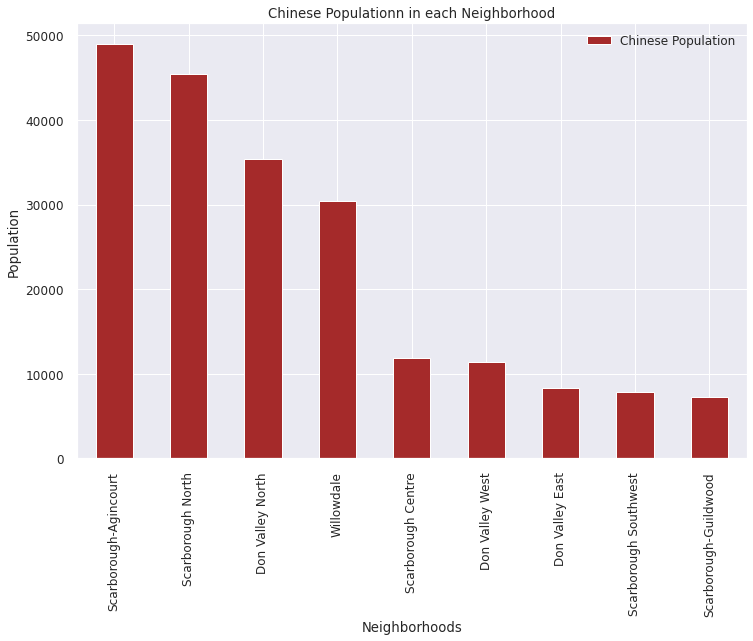

In [88]:
bar_graph = pop_chinese_DF_with_percent.sort_values(by='Chinese Population', ascending=False)
bar_graph.plot(kind='bar',x='Riding', y='Chinese Population',figsize=(12,8), color='brown')
plt.title("Chinese Populationn in each Neighborhood")
plt.xlabel("Neighborhoods")
plt.ylabel("Population")
plt.show()

In [89]:
#Altering the list to match the wikipedia page so we can retrieve the neighborhoods present in those Ridings
riding_list = pop_chinese_DF_with_percent['Riding'].to_list()
riding_list[riding_list.index('Scarborough Centre')] = 'Scarborough Centre (electoral district)'
riding_list[riding_list.index('Scarborough North')] = 'Scarborough North (electoral district)'
riding_list

['Scarborough Centre (electoral district)',
 'Scarborough Southwest',
 'Scarborough-Agincourt',
 'Scarborough-Guildwood',
 'Scarborough North (electoral district)',
 'Willowdale',
 'Don Valley North',
 'Don Valley West',
 'Don Valley East']

In [90]:
#Scraping wiki page to get the neighborhoods of ech Ridings


Riding_neighborhood_df = pd.DataFrame()

for item in riding_list:
    section = wp.WikipediaPage(item).section('Geography')
    start = section.index('neighbourhoods of') + 17
    stop = section.index('.',start)
    Riding_neighborhood_df = Riding_neighborhood_df.append({'Riding':item, 'Neighborhoods':section[start:stop]},ignore_index=True)
    

Riding_neighborhood_df = Riding_neighborhood_df[['Riding','Neighborhoods']]
Riding_neighborhood_df

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/wikipedia/wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file /opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/wikipedia/wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


DisambiguationError: "Willowdale" may refer to: 
Willowdale, Kansas
Willowdale, New Jersey
Willowdale, Nova Scotia (disambiguation)
Willowdale, Pennsylvania
Willowdale No. 153, Saskatchewan
Willowdale (provincial electoral district)
Willowdale, Toronto
Willowdale Airfield
Willowdale (electoral district)
Willowdale, West Virginia
Willowdale (Painter, Virginia)
Willowdale Elementary School
Willowdale Estate
Willowdale Estates, Alberta
Willowdale Township (disambiguation)
Willowvale, Eastern Cape
Willowvale
New Hampshire Historical Marker No. 185

In [91]:
#Merging the pop_chinese_DF_with_percent dataframe containing population information with the Riding_neighborhood_df dataframe.

Neigh_pop = pd.merge(pop_chinese_DF_with_percent, Riding_neighborhood_df, on='Riding')

Neigh_pop.drop(columns=['Riding'],inplace =True)
Neigh_pop

,Chinese Population,Neighborhoods
0,7797.240,"Birch Cliff, Oakridge, Cliffside, Kennedy Par..."
1,48985.750,"Steeles, L'Amoreaux, Tam O'Shanter-Sullivan, ..."
2,7179.165,"Guildwood, West Hill (west of Morningside Ave..."


After performing the data cleaning & data analysis we can identify that their no big relationship established in terms of the Chinese population & the popular Chinese restaurants.

Thus this marks end of the data cleaning & analyses step in this project. Next we will look into the predictive modeling. In the predictive modelling we are going to use Clustering techniques since this is analysis of unlabelled data. K-Means clustering is used to perform the analysis of the data at hand.

# Predictive Modeling
### Clustering Neighborhoods of Toronto:
We'll use some predictive analysis to try and cluster our neighborhoods in have chinese restaurant clusters so that we can avoid these areas for opening up a restaurant.

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:8: ConvergenceWarning: Number of distinct clusters (5) found smaller than n_clusters (6). Possibly due to duplicate points in X.
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:8: ConvergenceWarning: Number of distinct clusters (5) found smaller than n_clusters (7). Possibly due to duplicate points in X.
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:8: ConvergenceWarning: Number of distinct clusters (5) found smaller than n_clusters (8). Possibly due to duplicate points in X.
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:8: ConvergenceWarning: Number of distinct clusters (5) found smaller than n_clusters (9). Possibly due to duplicate points in X.
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:8: ConvergenceWarning: Number of distinct clusters (5) found smaller than 

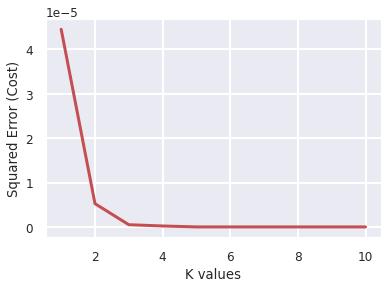

In [93]:
toronto_part_clustering = toronto_part.drop('Neighborhood', 1)

error_cost = []

for i in range(1,11):
    KM = KMeans(n_clusters = i, max_iter = 100)
    try:
        KM.fit(toronto_part_clustering)
    except ValueError:
        print("error on line",i)
    
    #calculate squared error for the clustered points
    error_cost.append(KM.inertia_/100)

#plot the K values aganist the squared error cost
plt.plot(range(1,11), error_cost, color='r', linewidth='3')
plt.xlabel('K values')
plt.ylabel('Squared Error (Cost)')
plt.grid(color='white', linestyle='-', linewidth=2)
plt.show()

It appears the a k value of either 2 or 3 is ideal. We will use a K-Value of 2 for ths project.

In [99]:
kclusters = 2

toronto_part_clustering = toronto_part.drop('Neighborhood', 1)

kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_part_clustering)

kmeans.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [101]:
toronto_part.drop(['Cluster Labels'],axis=1,inplace=True)
toronto_part.insert(0, 'Cluster Labels', kmeans.labels_)
toronto_merged = df4
# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(toronto_part.set_index('Neighborhood'), on='Neighborhood')
toronto_merged.dropna(subset=["Cluster Labels"], axis=0, inplace=True)
toronto_merged.reset_index(drop=True, inplace=True)
toronto_merged.head()

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Postal Code,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,Chinese Restaurant
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,0,0.00
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,0,0.00
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,0,0.01
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,0,0.00
4,M4E,East Toronto,The Beaches,43.676357,-79.293031,0,0.00


In [102]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11, width='90%', height='70%')

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels'].astype(int)):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
map_clusters

### Let's take a look at the clusters to see where we should avoid opeining up a chinese restaurant.

In [103]:
#Cluster 1
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1]

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,Chinese Restaurant
23,M4R,Central Toronto,"North Toronto West, Lawrence Park",43.715383,-79.405678,1,0.050000
35,M4X,Downtown Toronto,"St. James Town, Cabbagetown",43.667967,-79.367675,1,0.043478


In [104]:
#Cluster 0
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0]

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,Chinese Restaurant
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,0,0.000000
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,0,0.000000
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,0,0.010000
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,0,0.000000
4,M4E,East Toronto,The Beaches,43.676357,-79.293031,0,0.000000
5,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306,0,0.000000
6,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383,0,0.016129
7,M6G,Downtown Toronto,Christie,43.669542,-79.422564,0,0.000000
8,M5H,Downtown Toronto,"Richmond, Adelaide, King",43.650571,-79.384568,0,0.000000
9,M6H,West Toronto,"Dufferin, Dovercourt Village",43.669005,-79.442259,0,0.000000


# Results and Discussion:
##### Results
In this section, we will document all the findings from the above clustering , visualization, and exploratory analysis of the data. In this project, as the business problem started with identifying a good neighborhood to open a new Chinese restaurant, we looked into all the neighborhoods in Toronto, analysed the Chinese population in each neighborhood & spread of Chinese restaurants in those neighborhoods to come to conclusion about which neighborhood would be a better spot for opening a new Chinese restaurant. I have used data from web resources like Wikipedia, geospatial coordinates of Toronto neighborhoods, and Foursquare API, to set up a very realistic data-analysis scenario. We have found out that —

In those 11 boroughs we identified that only Central Toronto and Downtown Toronto, have a high number of Chinese restaurants with the help of Violin plots between Number of Chinese restaurants in Borough of Toronto.
In all the ridings, Scarborough North, Don Valley North, Scarborough-Agincourt, and Willowdale are the densely populated with Chinese crowd ridings.
With the help of clusters examination & violin plots, it appears that Downtown Toronto is already densely populated with Chinese restaurants. It is better idea to leave those boroughs out and consider only Scarborough for the new restaurant's location.
From the analysis presented, it is recommended to open a new Chinese restaurant in Scarborough borough (Scarborough-Agincourt) since it the highest Chinese population with the lowest number of Chinese restaurants. This presents a perfect opportunity to capture the highest amount of potential market share with the lowest amount of competition. 
##### Discussion
According to this analysis, Scarborough borough will provide least competition for the new upcoming Chinese restaurant as there is very little Chinese restaurants spread or no Chinese restaurants in the neighborhoods. Also looking at the population distribution looks like it is densely populated with Chinese crowd which helps the new restaurant by providing high customer potential traffic. Some of the drawbacks of this analysis are — the clustering is completely based only on data obtained from Foursquare API. Also, the Chinese population distribution in each neighborhood is also based on the 2016 census which is not up-to date. This population distribution would have changed by 2021 given 6 year gap in the data. Since population distribution of the Chinese crowd in each neighborhood & number of Chinese restaurants are the major feature in this analysis and it is not fully up-to date data, this analysis is far from being conclusory & it has lot of areas where it can be improved. However, it certainly provides us with some good insights, preliminary information on possibilities & a head start into this business problem by setting the step stones properly. Furthermore, this may also potentially vary depending on the type of clustering techniques that we use to examine the data.

This analysis also does not take into consideration the cost of starting a Chinese restaurant. It may be possible that Scarborough-Agincourt has extremely high rents and may prove to not be a suitable choice for Chinese restaurant. This would be worth looking into to identify the neighborhood with the best rent prices for opening a restaurant.

# Conclusion:
In conclusion, we have got a chance to on a business problem like how a real like data scientists would do. We have used many python libraries to fetch the data, to manipulate the contents & to analyze and visualize those datasets. We have made use of Foursquare API to explore the venues in neighborhoods of Toronto, then get good amount of data from Wikipedia which we scraped and visualized using various plots present in seaborn & matplotlib. We also applied machine learning technique to to predict the output given the data and used Folium to visualize it on a map. Also, some of the drawbacks or areas of improvements shows us that this analysis can further be improved with help more data and different machine learning techniques and bringing in some additional data to further scope the opportune neighborhoods. Hopefully, this project helps acts as initial guidance to take more complex real-life challenges using data-science.
